In [1]:
import os
import glob
import numpy as np
import torch
import random
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, Subset
from torchvision import transforms
from PIL import Image
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import kagglehub
import torchvision
from torchinfo import summary
from torchvision.utils import save_image
from torchvision.models import VGG16_Weights

/Users/dawid/PycharmProjects/ImbalancedDataProject/.venv/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [2]:
# Parametry modelu
IMG_SIZE = 128
CHANNELS = 3
LATENT_DIM = 512
HIDDEN_DIM = 2048
BATCH_SIZE = 16
EPOCHS = 100
PATIENCE = 70  # Liczba epok bez poprawy, po których trening się zatrzyma

# Konfiguracja
result_dir = 'results/'
if not os.path.exists(result_dir):
    os.makedirs(result_dir)



name = 'vae'
device = (
    torch.device("mps") if torch.backends.mps.is_available()
    else torch.device("cuda") if torch.cuda.is_available()
    else torch.device("cpu")
)
print(f"Training device: {device}")

Training device: mps


(128, 128, 3)


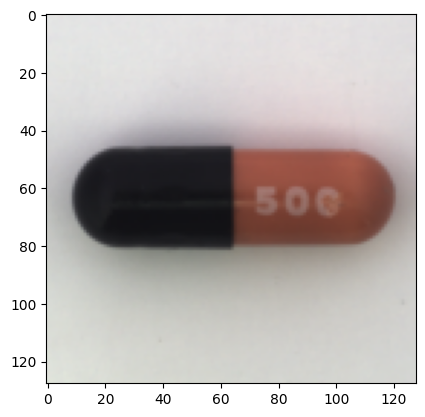

In [3]:
# Dataset (twój istniejący kod)
class CapsuleNegativeDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.image_paths = glob.glob(os.path.join(root_dir, '*'))
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image = Image.open(self.image_paths[idx]).convert('RGB')
        if self.transform:
            image = self.transform(image)
        return image

transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
])

# Ścieżka do danych (zmień na swoją)

path = kagglehub.dataset_download("tladilebohang/capsule-defects")

dataset = CapsuleNegativeDataset(
    root_dir=os.path.join(path, 'capsule/negative'),
    transform=transform
)

# Podział danych
full_indices = np.arange(len(dataset))
train_val_indices, test_indices = train_test_split(
    full_indices, test_size=0.2, random_state=42, shuffle=True
)
train_indices, val_indices = train_test_split(
    train_val_indices, test_size=0.2, random_state=42, shuffle=True
)

train_dataset = Subset(dataset, train_indices)
val_dataset = Subset(dataset, val_indices)
test_dataset = Subset(dataset, test_indices)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)


#Print first image
data_iter = iter(train_loader)
images = next(data_iter)  # 

image = images[0]

image = image.permute(1, 2, 0).numpy()
image = np.array(image)
print(image.shape)

plt.imshow(image)


In [4]:
# Model VAE
class VAE(nn.Module):
    def __init__(self):
        super(VAE, self).__init__()
        input_dim = IMG_SIZE * IMG_SIZE * CHANNELS

        # Encoder
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, HIDDEN_DIM),
            nn.ReLU(),
            nn.Dropout(p=0.3),
            nn.Linear(HIDDEN_DIM, int(HIDDEN_DIM * 0.85)),
            nn.ReLU(),
            nn.Dropout(p=0.3),
            nn.Linear(int(HIDDEN_DIM * 0.85), int(HIDDEN_DIM * 0.65)),
            nn.ReLU(),
            nn.Dropout(p=0.3),
            nn.Linear(int(HIDDEN_DIM * 0.65), HIDDEN_DIM // 2),
            nn.ReLU(),
        )

        self.fc_mu = nn.Linear(HIDDEN_DIM // 2, LATENT_DIM)
        self.fc_var = nn.Linear(HIDDEN_DIM // 2, LATENT_DIM)

        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(LATENT_DIM, HIDDEN_DIM // 2),
            nn.ReLU(),
            nn.Dropout(p=0.3),
            nn.Linear(HIDDEN_DIM // 2, int(HIDDEN_DIM * 0.65)),
            nn.ReLU(),
            nn.Dropout(p=0.3),
            nn.Linear(int(HIDDEN_DIM * 0.65), int(HIDDEN_DIM * 0.85)),
            nn.ReLU(),
            nn.Dropout(p=0.3),
            nn.Linear(int(HIDDEN_DIM * 0.85), HIDDEN_DIM),
            nn.ReLU(),
            nn.Linear(HIDDEN_DIM, input_dim),
            nn.Sigmoid()
        )


    def encode(self, x):
        x = x.view(x.size(0), -1)
        h = self.encoder(x)
        return self.fc_mu(h), self.fc_var(h)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        return self.decoder(z).view(-1, CHANNELS, IMG_SIZE, IMG_SIZE)

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar

In [5]:

class CNNVAE(nn.Module):
    def __init__(self):
        super(CNNVAE, self).__init__()

        # Encoder (konwolucje)
        self.encoder_conv = nn.Sequential(
            nn.Conv2d(CHANNELS, 32, kernel_size=4, stride=2, padding=1),  # [B, 32, IMG_SIZE/2, IMG_SIZE/2]
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=1),         # [B, 64, IMG_SIZE/4, IMG_SIZE/4]
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),        # [B, 128, IMG_SIZE/8, IMG_SIZE/8]
            nn.ReLU(),
            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1),       # [B, 256, IMG_SIZE/16, IMG_SIZE/16]
            nn.ReLU(),
            nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1),       # [B, 512, IMG_SIZE/32, IMG_SIZE/32]
            nn.ReLU()
        )

        # Ustalanie rozmiaru po przejściu przez encoder
        self.flatten_dim = 512 * (IMG_SIZE // 32) * (IMG_SIZE // 32)

        # Fully connected warstwy do latentnej przestrzeni
        self.fc_mu = nn.Linear(self.flatten_dim, LATENT_DIM)
        self.fc_var = nn.Linear(self.flatten_dim, LATENT_DIM)

        # Decoder (transponowane konwolucje)
        self.decoder_fc = nn.Sequential(
            nn.Linear(LATENT_DIM, self.flatten_dim),
            nn.ReLU()
        )

        self.decoder_conv = nn.Sequential(
            nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1),  # [B, 256, IMG_SIZE/16, IMG_SIZE/16]
            nn.ReLU(),
            nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1),   # [B, 128, IMG_SIZE/8, IMG_SIZE/8]
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),    # [B, 64, IMG_SIZE/4, IMG_SIZE/4]
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1),     # [B, 32, IMG_SIZE/2, IMG_SIZE/2]
            nn.ReLU(),
            nn.ConvTranspose2d(32, CHANNELS, kernel_size=4, stride=2, padding=1),  # [B, CHANNELS, IMG_SIZE, IMG_SIZE]
            nn.Sigmoid()  # Wartości wyjściowe w zakresie [0, 1]
        )

    def encode(self, x):
        x = self.encoder_conv(x)
        x = x.view(x.size(0), -1)  # Flatten
        mu = self.fc_mu(x)
        logvar = self.fc_var(x)
        return mu, logvar

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        x = self.decoder_fc(z)
        x = x.view(-1, 512, IMG_SIZE // 32, IMG_SIZE // 32)  # Reshape do rozmiaru przed dekonwolucją
        return self.decoder_conv(x)

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar



In [6]:

class PerceptualLoss(nn.Module):
    def __init__(self):
        super().__init__()
        # Używamy warstw VGG16 do ekstrakcji cech (bez warstw fully connected)
        self.vgg = torchvision.models.vgg16(weights=VGG16_Weights.IMAGENET1K_V1).features[:16].eval()
        # Zamrażamy wagi VGG (nie chcemy ich trenować)
        for param in self.vgg.parameters():
            param.requires_grad = False

    def forward(self, recon, target):
        # Normalizacja obrazów do zakresu VGG (ważne!)
        recon = (recon - 0.5) * 2  # Zakładając, że recon jest w [0, 1]
        target = (target - 0.5) * 2

        # Ekstrakcja cech
        recon_features = self.vgg(recon)
        target_features = self.vgg(target)

        # Strata to MSE między cechami
        return F.mse_loss(recon_features, target_features)

In [20]:
BCE_loss = nn.BCELoss(reduction='sum')
MSE_loss = nn.MSELoss(reduction='sum')


# Ta funkcja strat dawala dobre efekty generowania, ale ma tendencje do usredniania probek i bardzo malo sa zroznicowane wyjsciowe obrazy. 
def vae_loss(recon_x, x, mu, logvar, perceptual_loss):
    # Perceptual Loss dla cech
    percep_loss = perceptual_loss(recon_x, x)

    # Standardowa strata VAE (BCE + KLD)
    bce = F.binary_cross_entropy(recon_x, x, reduction='sum')
    kld = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

    # Ważone sumowanie (można dostosować wagi)
    return 0.7 * percep_loss + 0.3 * bce + 0.1* kld



def vae_loss_tmp(recon_x, x, mu, logvar):
    #BCE = F.binary_cross_entropy(recon_x, x,reduction='sum')
    #BCE = BCE_loss(recon_x, x)
    MSE = MSE_loss(recon_x, x)
    # BCE = F.mse_loss(recon_x, x, size_average=False)

    # see Appendix B from VAE paper:
    # Kingma and Welling. Auto-Encoding Variational Bayes. ICLR, 2014
    # 0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
    KLD = -0.5 * torch.mean(1 + logvar - mu.pow(2) - logvar.exp())

    return MSE + 0.1*KLD




def vae_loss_from_article(recon_x, x, mu, logvar):
    BCE = F.binary_cross_entropy(recon_x, x, size_average=False)
    # BCE = F.mse_loss(recon_x, x, size_average=False)

    # see Appendix B from VAE paper:
    # Kingma and Welling. Auto-Encoding Variational Bayes. ICLR, 2014
    # 0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
    KLD = -0.5 * torch.mean(1 + logvar - mu.pow(2) - logvar.exp())

    return BCE + KLD


In [23]:
# Inicjalizacja
perceptual_loss = PerceptualLoss().to(device)

model = VAE().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
dummy_input = torch.zeros(1, CHANNELS, IMG_SIZE, IMG_SIZE).to(device)  
summary(model, input_data=dummy_input)

Layer (type:depth-idx)                   Output Shape              Param #
VAE                                      [1, 3, 128, 128]          --
├─Sequential: 1-1                        [1, 1024]                 --
│    └─Linear: 2-1                       [1, 2048]                 100,665,344
│    └─ReLU: 2-2                         [1, 2048]                 --
│    └─Dropout: 2-3                      [1, 2048]                 --
│    └─Linear: 2-4                       [1, 1740]                 3,565,260
│    └─ReLU: 2-5                         [1, 1740]                 --
│    └─Dropout: 2-6                      [1, 1740]                 --
│    └─Linear: 2-7                       [1, 1331]                 2,317,271
│    └─ReLU: 2-8                         [1, 1331]                 --
│    └─Dropout: 2-9                      [1, 1331]                 --
│    └─Linear: 2-10                      [1, 1024]                 1,363,968
│    └─ReLU: 2-11                        [1, 1024]     

In [21]:
# Trenowanie
def train(epoch):
    model.train()
    train_loss = 0
    for data in train_loader:
        data = data.to(device)
        optimizer.zero_grad()
        recon_batch, mu, logvar = model(data)
        loss = vae_loss_tmp(recon_batch, data, mu, logvar)/data.size(0)
        train_loss += loss.item()
        loss.backward()
        optimizer.step()

    train_loss /= len(train_loader.dataset)
    print(f'Train Epoch: {epoch} | Loss: {train_loss:.4f}')
    return train_loss
    


def validate(epoch):
    model.eval()
    validate_loss = 0
    with torch.no_grad():
        for data in val_loader:
            data = data.to(device)
            recon, mu, logvar = model(data)
            validate_loss += vae_loss_tmp(recon, data, mu, logvar).item()/data.size(0)

    validate_loss /= len(val_loader.dataset)
    print(f'Validate Epoch: {epoch} | Loss: {validate_loss:.4f}')
    return validate_loss

# Wizualizacja rekonstrukcji
def visualize_reconstruction(epoch):
    model.eval()
    with torch.no_grad():
        sample = next(iter(train_loader)).to(device)
        
        recon, _, _ = model(sample)

        fig, axes = plt.subplots(2, BATCH_SIZE, figsize=(32, 8))
        for i in range(BATCH_SIZE):
            axes[0, i].imshow(sample[i].cpu().permute(1, 2, 0))
            axes[0, i].axis('off')
            axes[1, i].imshow(recon[i].cpu().permute(1, 2, 0))
            axes[1, i].axis('off')
        plt.savefig(f'{result_dir}/recon_{epoch}.png')
        plt.close()

In [ ]:
# Główna pętla
best_loss = float('inf')
no_improve = 0  # Licznik epok bez poprawy

for epoch in range(1, EPOCHS + 1):
    train_loss=train(epoch)
    validate_loss = validate(epoch)
    visualize_reconstruction(epoch)

    # Zapisywanie najlepszego modelu
    if train_loss < best_loss:
        best_loss = train_loss
        torch.save(model.state_dict(), f'{result_dir}/{name}_best.pth')
        no_improve = 0  
    else:
        no_improve += 1

    # Early stopping
    if no_improve >= PATIENCE:
        print(f'\nEarly stopping after {PATIENCE} epochs without improvement')
        break

    print(f'Epoch {epoch}: Train Loss = {train_loss:.4f} (Best: {best_loss:.4f})')

In [11]:
# Ocena na zbiorze testowym
model.load_state_dict(torch.load(f'{result_dir}/{name}_best.pth'))
model.eval()
test_loss = 0
with torch.no_grad():
    for data in test_loader:
        data = data.to(device)
        recon, mu, logvar = model(data)
        print(mu.mean(),logvar.mean())
        test_loss += vae_loss_tmp(recon, data, mu, logvar).item()

print(f'Final Test Loss: {test_loss / len(test_loader.dataset):.4f}')

tensor(-0.0101, device='mps:0') tensor(-0.2084, device='mps:0')
tensor(-0.0102, device='mps:0') tensor(-0.2106, device='mps:0')
Final Test Loss: 45.8800


In [12]:
def generate_from_params(model, mu, logvar, num_samples=1, device='cpu'):
    """
    Generuje próbki z rozkładu N(mu, exp(logvar))
    
    Args:
        model: VAE model
        mu: tensor (LATENT_DIM,) - średnia
        logvar: tensor (LATENT_DIM,) - log-wariancja
        num_samples: int - liczba próbek do wygenerowania
        device: str - urządzenie (cpu/cuda)
    Returns:
        Tensor (num_samples, CHANNELS, IMG_SIZE, IMG_SIZE)
    """
    model.eval()
    with torch.no_grad():
        # Rozszerz mu i logvar dla num_samples
        mu = mu.unsqueeze(0).expand(num_samples, -1).to(device)          # (num_samples, LATENT_DIM)
        logvar = logvar.unsqueeze(0).expand(num_samples, -1).to(device)  # (num_samples, LATENT_DIM)

        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)  # (num_samples, LATENT_DIM)
        z = mu + eps * std

        samples = model.decode(z)    # (num_samples, CHANNELS, IMG_SIZE, IMG_SIZE)
    return samples

In [13]:
def generate_from_accurate_params(model, mu, logvar, num_samples=1, device='cpu'):
    """
    Generuje próbki z rozkładu N(mu, exp(logvar))
    
    Args:
        model: VAE model
        mu: tensor (LATENT_DIM,) - średnia
        logvar: tensor (LATENT_DIM,) - log-wariancja
        num_samples: int - liczba próbek do wygenerowania
        device: str - urządzenie (cpu/cuda)
    Returns:
        Tensor (num_samples, CHANNELS, IMG_SIZE, IMG_SIZE)
    """
    model.eval()
    with torch.no_grad():
        
        mu = mu.expand(num_samples, -1).to(device)          # kształt: [5, latent_dim]
        logvar = logvar.expand(num_samples, -1).to(device)  # kształt: [5, latent_dim]

        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)  # (num_samples, LATENT_DIM)
        z = mu + eps * std

        samples = model.decode(z)    # (num_samples, CHANNELS, IMG_SIZE, IMG_SIZE)
    return samples

In [14]:
def save_samples(samples, output_dir=result_dir):
    for i, sample in enumerate(samples):
        # Zapis do pliku PNG
        save_image(sample, os.path.join(output_dir, f"sample_{i}.png"))

In [15]:
# Przykład użycia:
device = (
    torch.device("mps") if torch.backends.mps.is_available()
    else torch.device("cuda") if torch.cuda.is_available()
    else torch.device("cpu")
)
desired_variance = 0.5
desired_mu = 0.3

vae = VAE().to(device)
state_dict = torch.load(result_dir+'vae_best.pth', map_location='cpu')
vae.load_state_dict(state_dict)
vae.eval()

mu = torch.log(torch.tensor(desired_mu)) * torch.ones(LATENT_DIM).to(device)
logvar = torch.log(torch.tensor(desired_variance)) * torch.ones(LATENT_DIM).to(device)
samples = generate_from_params(vae, mu, logvar, num_samples=5, device=device)

save_samples(samples)

In [16]:
# Przykład użycia:
device = (
    torch.device("mps") if torch.backends.mps.is_available()
    else torch.device("cuda") if torch.cuda.is_available()
    else torch.device("cpu")
)


vae = VAE().to(device)
state_dict = torch.load(result_dir+'vae_best.pth', map_location='cpu')
vae.load_state_dict(state_dict)
vae.eval()

data = next(iter(test_loader)).to(device)
tmp_image = data[0]  # Zakładając, że data[0] to obrazy z batcha

# Dodaj wymiar batcha, jeśli obraz jest pojedynczy
tmp_image = tmp_image.unsqueeze(0)  # Dodaje wymiar batcha na początku



# Upewnij się, że obraz jest na odpowiednim urządzeniu
tmp_image = tmp_image.to(device)

# Przekazujemy obraz do modelu
recon, mu, logvar = model(tmp_image)

samples = generate_from_accurate_params(vae, mu, logvar, num_samples=5, device=device)

save_samples(samples)